## Doc2vec - Proof of Concept
With the following implementation we are trying to explore the capabilities of **Doc2vec** model in our dataset.
The implementation of the model was based on **Gensim** library.

**training_dataset**: a different document for each Github Issue.
**test_dataset**: a different document with logs from each failed Jenkins pipeline.
**task**: Document Similarity
**input**: Jenkins logs
**input_type**: different texts
**output**: top 3 most similar GithubIssues
**measure**: accuracy_score

**Important Note for accuracy measure**
The current model is potentially going to serve a specific GUI functionality.
This functionality considers a successful match of the GithubIssue document and the JenkinsLog,
if the first one is contained in the top 3 output documents.

In [1]:
import gensim
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from MachineLearningPrototype.utils.preprocess_data import create_models_datasets

#### Declaration of training and test data

In [2]:
train_data_path = '../../data/GitHubData/IssueContent'
train_data_extra_path = '../../data/GitHubData/IssueContentQuote'
test_data_path = '../../data/JenkinsData'
model_name = 'doc2vec'

df_git = create_models_datasets(train_data_path, train_data_extra_path)
df_jenkins = create_models_datasets(test_data_path, "")

#### Preparation of data for Doc2vec

In [3]:
## Create TaggedDocument objects for the Doc2vec model
doc2vec_data = []
count=0
for idx,doc in enumerate(df_git.iterrows()):
    # tokenize documents with gensim's simple_preprocess
    words = gensim.utils.simple_preprocess(df_git.iloc[idx]['content'])
    tags = df_git.iloc[idx]['labels']
    doc2vec_data.append(TaggedDocument(words=words, tags=[tags]))
    count +=1


#### Training Doc2vec
During the training of our models we applied both of the provided training algorithms of **Doc2vec** (PV-DM','PV-DBOW') implementation.
Furthermore, we tried different values for the parameters of **window_size** and **embeddings_size**.

We applied multiple execution, with different parameters' settings in order to retrieve more indicative samples of doc2vec performance.
Our purpose was not to find the best doc2vec model for our dataset.

The measure of similarity for our document classification task is the cosine distance.
Cosine distance indicates the proximity of two different documents in a common semantic space.
This measure has been applied through the usage of **most_similar** function that is provided from the **Gensim Doc2vec** model.



In [4]:
def train_doc2vec_model(vector_size,window,dm,epochs):
    # set model
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vector_size, window=window, sample=0.00001, dm=dm, epochs=epochs)
    # initialize vocabulary
    model.build_vocab(doc2vec_data)
    # train Doc2Vec model
    model.train(doc2vec_data, total_examples=model.corpus_count, epochs=model.epochs)
    # Uncomment the next 3 lines in case you want to save each trained model
    #
    #model.dv.save_word2vec_format(os.path.join(os.getcwd(),model_name))
    #model.save(model_name + '.model')
    return model

In [5]:
vectors_size = [50,100,200,300]
windows = [2,4,6,8,10]
algorithm_dict = {'PV-DM':1,'PV-DBOW':0}

epoch = 20

# dataframe to store the results from the different executions
executions_df = pd.DataFrame(columns = ['algorithm', 'dimension', 'window','epoch','f1score','accuracy','precision',
                                     'recall'])

count = 0
for dim in vectors_size:
    for window in windows:
        for key in algorithm_dict:

            model_doc2vec = train_doc2vec_model(dim,window,algorithm_dict[key],epoch)
            # Uncomment the next 2 lines in case you want to load each trained model

            #model_doc2vec = gensim.models.doc2vec.Doc2Vec.load(model_name + '.model')

            docs_pred = []
            docs_true = [1] * len(df_jenkins)

            for idx in range(len(df_jenkins)):
                # calculate document embeddings for the incoming document
                inferred_vector = model_doc2vec.infer_vector(gensim.utils.simple_preprocess(df_jenkins.iloc[idx]['content']))
                # retrieve top 3 most similar documents based on the cosine distance
                topn_src_similar = [i[0].split("_",1)[1] for i in model_doc2vec.dv.most_similar(positive=inferred_vector,topn=3)]
                # retrieve file name without prefix ("git","jenkins")
                label = str(df_jenkins.iloc[idx]['labels']).split("_",1)[1]

                if label in topn_src_similar:
                    predicted = True
                else:
                    predicted = False

                docs_pred.append(int(predicted))

            count +=1
            executions_df.loc[count] = [key, dim, window, epoch,round(f1_score(docs_true, docs_pred),3),
                                        round(accuracy_score(docs_true, docs_pred),3),
                                        round(precision_score(docs_true, docs_pred),3),
                                        round(recall_score(docs_true, docs_pred),3)]


In [6]:
# save results in a csv format
executions_df.to_csv('executions_df', index=False)
executions_df = pd.read_csv('executions_df', index_col=False)
print(executions_df.sort_values(by='accuracy',ascending=False).head())

   algorithm  dimension  window  epoch  f1score  accuracy  precision  recall
39   PV-DBOW        300      10     20    0.583     0.412        1.0   0.412
37   PV-DBOW        300       8     20    0.583     0.412        1.0   0.412
23   PV-DBOW        200       4     20    0.583     0.412        1.0   0.412
35   PV-DBOW        300       6     20    0.583     0.412        1.0   0.412
19   PV-DBOW        100      10     20    0.583     0.412        1.0   0.412


#### Comparison of different Doc2vec training algorithms
After the usage of boxplot visualization technique, it is obvious that
<u>for our dataset</u> and <u>the current training settings</u> **PV-DBOW overwhelms PV-DM**.

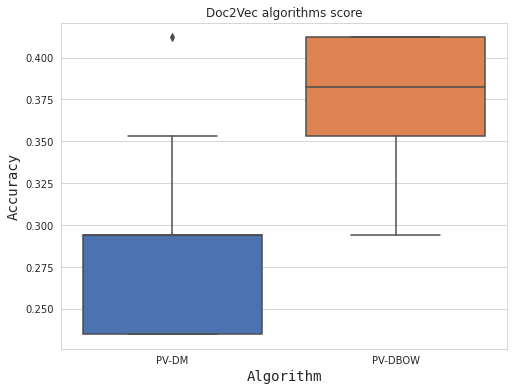

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set()
sns.boxplot(ax=ax,x='algorithm', y='accuracy', saturation=1, data=executions_df)
# specify axis labels
plt.xlabel('Algorithm', size=14, family='monospace')
plt.ylabel('Accuracy', size=14, family='monospace')
plt.title('Doc2Vec algorithms score')
plt.show()

#### Inspection of window_size and embeddings_size parameters
We can also notice that:
- embeddings with a size of **200** and **300**, achieved the highest score for certain windows sizes.
- embeddings of size **100** managed also to achieve the highest score with a setting of 2 windows size.

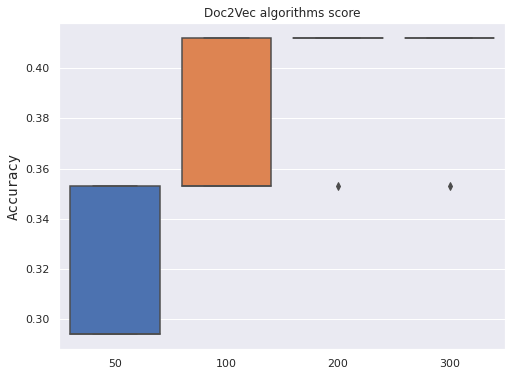

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set()
sns.boxplot(ax=ax,x='dimension', y='accuracy',saturation=1,
            data=executions_df.loc[(executions_df['algorithm'] == 'PV-DBOW')][['accuracy','dimension']])
# specify axis labels
plt.xlabel('', size=14, family='monospace')
plt.ylabel('Accuracy', size=14, family='monospace')
plt.title('Doc2Vec algorithms score')
plt.show()

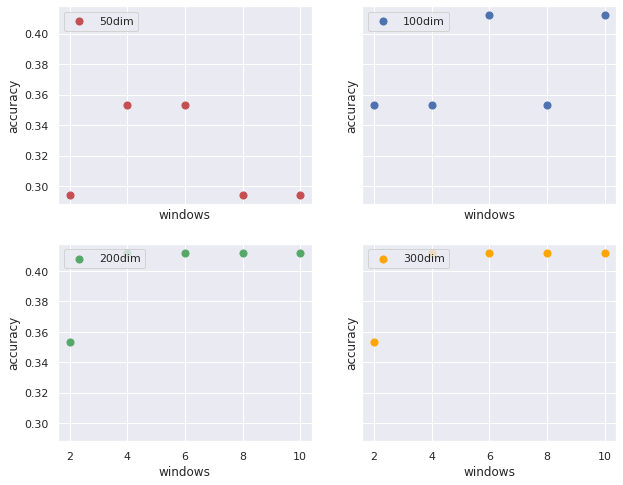

In [9]:
fig, axis = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True,figsize=(10,8))

# indicate different subplots
rownum = colnum = 0
# subplots' colors
colors = itertools.cycle(["r", "b", "g","orange"])

for idx,dim in enumerate(vectors_size):
    if (idx % 2) == 0 and idx!=0:
        rownum +=1
        colnum=0

    x = executions_df.loc[(executions_df['algorithm'] == 'PV-DBOW') & (executions_df['dimension'] == dim)][['window']]
    y = executions_df.loc[(executions_df['algorithm'] == 'PV-DBOW') & (executions_df['dimension'] == dim)][['accuracy']]
    label = str(dim)+"dim"
    axis[rownum][colnum].scatter(x,y,label = label,s=50,color=next(colors))
    #axis[rownum][colnum].title.set_text(key)
    axis[rownum][colnum].legend(loc="upper left")
    axis[rownum][colnum].set_xlabel('windows')
    axis[rownum][colnum].set_ylabel('accuracy')

    colnum +=1
plt.rcParams['axes.grid'] = True
#plt.ylabel('accuracy') #xlabel
#plt.xlabel('window') #ylabel
plt.show()

### Results
**Doc2vec** model managed to achieve a score of **0.412** with quite different setups in terms of:
- **window_size**
- **embeddings_size**

We need to mention that from our initial tests the score of 0.412 was obtainable only from a model with embeddings_size of 300.
After tweaking the parameter of **sample** ($1^{-3}$ to $1^{-5}$),
we were able to obtain the maximum accuracy score also with models which had embeddings_size of 200 or 100.